# 7. 네이버 영화리뷰 감성분석 도전하기

### 0. 사전학습
- 사전학습 : <a href="https://github.com/e9t/nsmc">  lms 노드 정리 </a> 

<mark><b>[진행 순서]</b>
    
[준비] 심볼릭 링크 연결
- ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data
- 영화리뷰 데이터 링크 : <a href="https://github.com/e9t/nsmc"> 바로가기 </a>
    
1. 데이터 준비와 확인
2. 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

3. 모델구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
    
4. 모델구성 및 validation set 구성   
    
5. 모델 훈련 개시

6. Loss, Accuracy 그래프 시각화

7. 학습된 Embedding 레이어 분석

8. 한국어 Word2Vec 임베딩 활용하여 성능개선    

### 1. 데이터 준비와 확인

In [1]:
# 1. 데이터 준비와 확인

import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import gensim

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2. 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab  #konlpy 한국어 자연어 처리를 위한 파이썬 라이브러리

tokenizer = Mecab() # mecab() 은전한잎 형태소분석기
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []  # lms 노드의 x_trin 대소문자 구분
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4) #-4는 인덱스 정의 PAD,BOS,UNK, UNUSE 4개인가?
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # 텍스트를 숫자로 변경시 {텍스트:인덱스} 구조여야 한다.
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index 

In [3]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()} # 텍스트를 숫자로 변경시 {텍스트:인덱스} 구조여야 한다.

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3. 모델구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [7]:
# 데이터셋 내 문장 길이 확인

print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [8]:
# IMDB 리뷰 데이터셋과 달리 네이버는 별도의 규칙이 없어 word_to_index, index_to_word 보정(+3을 해야 실제 맵핑 작업) 생략
# 케라스 패딩을 위한 도구  pad_sequences() 로 활용(pad_sequences : 앞에 0을 채운다.)

total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)

#max_len의 인자로 정수를 주면, 해당 정수로 모든 문서의 길이를 동일하게 하며 값설젇이 전체 모델 성능에 영향
print('pad_sequences maxlen : ', maxlen) 
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
# padding 방식 변경해 보기 -앞쪽('pre') RNN은 입력데이터가 순차적으로 처리 마지막 입력이 무의미, 'pre'가 훨씬 유리

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'], #PAD 오류시 2. 데이터 로드 <PAD> 설정 필요
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


### 4. 모델구성 및 validation set 구성
- 모델 구성 : RNN 모델 LSTM / CNN 모델 GlobalMaxPooling1D, Conv1D
- validation set (검증셋) 구성

In [10]:
# 모델 설계
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 41  # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다.

In [11]:
# 1) LSTM 모델
model = keras.Sequential(name='LSTM')
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 41)          410000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1600      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 411,681
Trainable params: 411,681
Non-trainable params: 0
_________________________________________________________________


In [12]:
# 2) CNN 계열의 GlobalMaxPooling1D() 활용하기 (정해진 필터 크기에서 최댓값 추출)

model = keras.Sequential(name='GlobalMaxPooling1D')
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary() 

Model: "GlobalMaxPooling1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
global_max_pooling1d (Global (None, 41)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 336       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 410,345
Trainable params: 410,345
Non-trainable params: 0
_________________________________________________________________


In [13]:
# 3) CNN 계열의 Conv1D 활용하기 (장점 : 병렬처리로 학습속도가 빠름)


model = keras.Sequential(name='Conv1D')
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          4608      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9    

In [14]:
# 훈련용 데이터셋 80000건을 분리하여 검증셋(validation set)으로 사용

# 총 146182건 훈련용 데이터중에 80000건 validation set  분리
x_val = X_train[:80000]   
y_val = y_train[:80000]


partial_x_train = X_train[80000:]  
partial_y_train = y_train[80000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(66182, 41)
(66182,)


### 5. 모델 훈련 개시

In [15]:
# 모델 학습

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
130/130 [==============================] - 9s 39ms/step - loss: 0.6392 - accuracy: 0.6314 - val_loss: 0.3769 - val_accuracy: 0.8346
Epoch 2/20
130/130 [==============================] - 2s 14ms/step - loss: 0.3356 - accuracy: 0.8587 - val_loss: 0.3546 - val_accuracy: 0.8456
Epoch 3/20
130/130 [==============================] - 2s 14ms/step - loss: 0.2807 - accuracy: 0.8874 - val_loss: 0.3598 - val_accuracy: 0.8460
Epoch 4/20
130/130 [==============================] - 2s 14ms/step - loss: 0.2394 - accuracy: 0.9077 - val_loss: 0.3738 - val_accuracy: 0.8430
Epoch 5/20
130/130 [==============================] - 2s 13ms/step - loss: 0.1913 - accuracy: 0.9310 - val_loss: 0.3968 - val_accuracy: 0.8407
Epoch 6/20
130/130 [==============================] - 2s 13ms/step - loss: 0.1430 - accuracy: 0.9530 - val_loss: 0.4369 - val_accuracy: 0.8389
Epoch 7/20
130/130 [==============================] - 2s 14ms/step - loss: 0.1015 - accuracy: 0.9691 - val_loss: 0.4903 - val_accuracy: 0.8350

In [16]:
# 모델 테스트셋으로 평가  
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 1.0969 - accuracy: 0.8156
[1.0968801975250244, 0.8155501484870911]


### 6. Loss, Accuracy 그래프 시각화

<mark><b>[진행 순서]</b>

- 그래프 Training and validation loss로 트레이닝 최적점 추정
- 그래프 Training and validation accuracy 로 트레이닝 최적점 추정

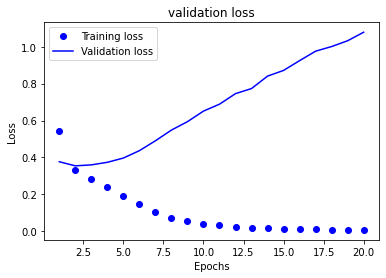

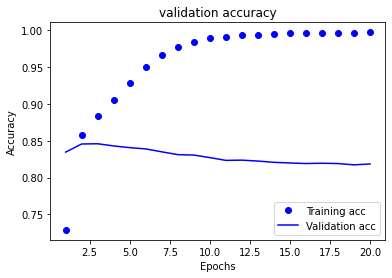

In [17]:
#그래프 Training and validation loss로 트레이닝 최적점 추정

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')

# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('validation loss')
plt.xlabel('Epochs')  
plt.ylabel('Loss')
plt.legend()

plt.show()

#그래프 Training and validation accuracy 로 트레이닝 최적점 추정

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('validation accuracy')
plt.xlabel('Epochs')  
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- validation의 loss 그래프에서 epochs 값이 증가할수록 training의 loss 감소
- validation의 loss 그래프에서 epochs 값이 증가할수록 validation의 loss 증가
- validation의 accuracy 그래프에서 epochs 값이 증가할수록 training acc의  accuracy 증가하다가 유지
- validation의 accuracy 그래프에서 epochs 값이 증가할수록  validation acc의 accuracy 일시 증가후 감소 유지

### 7. 학습된 Embedding 레이어 분석

In [18]:
# 한국어 Word2Vec 임베딩 활용하여 성능개선

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 41)


In [19]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [20]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([ 0.05663612, -0.08699958,  0.05780187,  0.07864043, -0.04940485,
        0.20793457,  0.01926316,  0.08891852, -0.04394628,  0.07271011,
       -0.06528407,  0.02669313,  0.12130702,  0.00312114,  0.01767844,
        0.04066906, -0.03913803,  0.01345666,  0.05978143, -0.02426713,
       -0.03113683,  0.09544107, -0.09680764,  0.07145077, -0.02347419,
        0.05153616,  0.06839513, -0.03140923, -0.05378296,  0.01341095,
       -0.07600945, -0.04708351,  0.03415855,  0.02281346,  0.08404466,
       -0.05248936,  0.0237732 ,  0.11948896,  0.09571345, -0.05268247,
        0.08005922], dtype=float32)

In [21]:
word_vectors.similar_by_word("재미")

[('특별', 0.5941540598869324),
 ('걱정', 0.5788195729255676),
 ('스파이', 0.5645768046379089),
 ('송강호', 0.5641075968742371),
 ('때리', 0.5491730570793152),
 ('경', 0.5460623502731323),
 ('새롭', 0.5387253165245056),
 ('해운대', 0.5370370149612427),
 ('동화책', 0.5369858741760254),
 ('당', 0.5348315238952637)]

In [22]:
word_vectors.similar_by_word("짜증")

[('거늘', 0.7884586453437805),
 ('연쇄', 0.7711998820304871),
 ('전용', 0.7695522308349609),
 ('괴상', 0.7682079076766968),
 ('별개', 0.7625026702880859),
 ('김고은', 0.7608113288879395),
 ('퇴', 0.7604967355728149),
 ('잔치', 0.7596117854118347),
 ('졸작', 0.7570698261260986),
 ('드만', 0.7570661902427673)]

### 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

In [23]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['재미']
vector.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


(200,)

In [24]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("재미")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  


[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [25]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [26]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9

In [27]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
130/130 [==============================] - 8s 49ms/step - loss: 0.6753 - accuracy: 0.5607 - val_loss: 0.5447 - val_accuracy: 0.7256
Epoch 2/20
130/130 [==============================] - 4s 32ms/step - loss: 0.4923 - accuracy: 0.7636 - val_loss: 0.4375 - val_accuracy: 0.7990
Epoch 3/20
130/130 [==============================] - 4s 32ms/step - loss: 0.3897 - accuracy: 0.8302 - val_loss: 0.4012 - val_accuracy: 0.8213
Epoch 4/20
130/130 [==============================] - 4s 32ms/step - loss: 0.3276 - accuracy: 0.8627 - val_loss: 0.3804 - val_accuracy: 0.8338
Epoch 5/20
130/130 [==============================] - 4s 32ms/step - loss: 0.2884 - accuracy: 0.8821 - val_loss: 0.3774 - val_accuracy: 0.8372
Epoch 6/20
130/130 [==============================] - 4s 32ms/step - loss: 0.2567 - accuracy: 0.8984 - val_loss: 0.3845 - val_accuracy: 0.8376
Epoch 7/20
130/130 [==============================] - 4s 32ms/step - loss: 0.2295 - accuracy: 0.9107 - val_loss: 0.4023 - val_accuracy: 0.8349

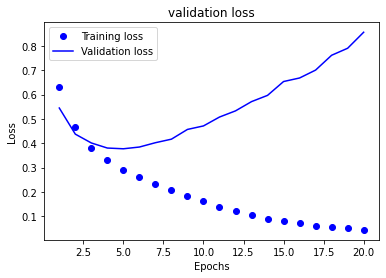

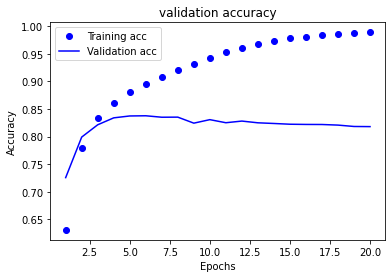

In [28]:
#그래프 Training and validation loss로 트레이닝 최적점 추정

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')

# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('validation loss')
plt.xlabel('Epochs')  
plt.ylabel('Loss')
plt.legend()

plt.show()

#그래프 Training and validation accuracy 로 트레이닝 최적점 추정

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('validation accuracy')
plt.xlabel('Epochs')  
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [30]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.9029 - accuracy: 0.8125
[0.9028906226158142, 0.8124987483024597]


## 회고
1. gensim name 에러로 문제 발생 -> 버전 업데이트 pip install -U gensim==3.8.3 -> import gensim 으로 처리
2. 5. 모델 훈련 개시에서 데이터셋의 val_loss 값이 거의 1.0867 나와서 test 진행
- 데이터셋 1만 단위인 경우 accuracy 0.8221로 노출
  val_loss 값이 거의 1.0867로 거의 나와서, 빈 데이터가 많이 있지 않을까 해서 데이터셋을 8만으로 변경 시도
- 데이터셋 8만 단위인 경우 0.8087로 노출로 정확도는 떨어졌지만 val_loss 는 Epoch가 낮을수록 loss가 감소된것을 확인 할수 있었음.
3. Word2Vec 반영후 validation의 loss 그래프에서 y축의 loss가 최대 1.0 에서 0.8로 줄었다. 성능 향상!!
4. Word2Vec 반영후 그래프에서 training loss의 파란색 점들이  균일하게 보정된것 같이 보인다.